# Exploring the Raw Data Structure
In this notebook, we investigate the provided row counts matrices, select the existing matrices and merge them using scanpy and anndata.

In [1]:
! ls -lh /media/gambino/students_workdir/ibp/new_data 

total 108K
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:55 GC1004281_E2
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:55 GC1004282_F2
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:55 GC1004283_G2
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:56 GC1004284_F4
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:56 GC1004285_G4
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:57 GC1004286_H4
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:57 GC108651_SI-GA-C3
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:57 GC108652_SI-GA-D3
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:57 GC108653_SI-GA-E3
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:58 GC110299_SI-GA-E8
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:58 GC110300_SI-GA-F8
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:59 GC110301_SI-GA-G8
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:59 GC110994_SI-GA-B6
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:59 GC110995_SI-GA-C6
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:59 GC110996_SI-GA-D6
drwxrwxrwx 3 cey cey 4,0K Nov  6 11:59 GC111283_SI-GA-D7
drwxrwxrwx 3 cey cey 4,0K Nov  6 12:00 GC111284_SI-GA-E7
drwxrwxrwx 3 cey cey 4,0K Nov  6 12:00 GC111285_SI

In [2]:
import os
import pandas as pd
import anndata as ann

DATA_DIR = "/media/gambino/students_workdir/ibp/new_data"
samples = sorted(os.listdir(DATA_DIR))
samples_desc = pd.read_excel("/media/gambino/students_workdir/ibp/Colon_ERC.xlsx")

missing_samples = samples_desc.loc[~samples_desc["GC code"].isin(samples), "GC code"]
print("Number of Existing Sample Folders:", len(samples))
existing_raw_matrices=[]
print("##################################################################################################")
for sample in samples:
    sample_path = os.path.join(DATA_DIR, sample)
    contents = os.listdir(os.path.join(sample_path, "outs"))
    tissue_row = samples_desc.loc[samples_desc["GC code"] == sample, "layer"]

    if not tissue_row.empty:
        tissue = tissue_row.iloc[0]
    else:
        tissue = "N/A"

    has_filtered_matrix = "filtered_feature_bc_matrix.h5" in contents
    has_raw_matrix = "raw_feature_bc_matrix.h5" in contents
    if has_raw_matrix:
        existing_raw_matrices.append(sample)
    # Calculate folder size
    folder_size = sum(os.path.getsize(os.path.join(sample_path, "outs",f)) for f in contents)

    # Prettify the output
    print(
        f"{sample:<18} - Tissue: {tissue:<15}, "
        f"filtered_feature_bc_matrix.h5: {has_filtered_matrix:<2}, "
        f"raw_feature_bc_matrix.h5: {has_raw_matrix:<2}, "
        f"Folder Size: {folder_size / (1024 * 1024):.2f} MB"
    )
print("##################################################################################################")
print("Missing Samples Folders:", missing_samples.values.tolist())
print(f"Existing Raw Files:{existing_raw_matrices}")

Number of Existing Sample Folders: 27
##################################################################################################
GC1004281_E2       - Tissue: Muscularis     , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 403.31 MB
GC1004282_F2       - Tissue: Submucosa      , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 437.70 MB
GC1004283_G2       - Tissue: Lamina Propria , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 285.79 MB
GC1004284_F4       - Tissue: Muscularis     , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 499.47 MB
GC1004285_G4       - Tissue: Submucosa      , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 481.75 MB
GC1004286_H4       - Tissue: Lamina Propria , filtered_feature_bc_matrix.h5: 1 , raw_feature_bc_matrix.h5: 1 , Folder Size: 501.58 MB
GC108651_SI-GA-C3  - Tissue: Muscularis     , filtered_feat

Looks like there are quite some missing sample folder all together, and some folders with no raw counts matrices inside. We need to discuss these anomalies with the lab supervisor.
Next, we merge the different files and assign each their corresponding sample ids.

In [3]:
import scanpy as sc

adatas = [] 
adatas_size = {sample:0 for sample in samples}
for filename in existing_raw_matrices: 
    adata = sc.read_10x_h5(os.path.join(DATA_DIR, filename, "outs", "filtered_feature_bc_matrix.h5"))
    adata.var_names_make_unique() 
    adata.obs['batch'] = filename
    adatas.append(adata)
    adatas_size[filename]=len(adata)


combined = ann.concat(adatas, merge="same")


/media/gambino/students_workdir/anis/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/anis/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/anis/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/anis/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.w

Quick quality checks:

In [32]:
print(sum(adata.shape[0] for adata in adatas))
print(combined.shape[0])

178608
178608


In [33]:
print(list(adata.shape[1] for adata in adatas))
print(combined.shape[1])

[36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601, 36601]
36601


In [34]:
combined.obs_names,combined.obs_keys

(Index(['AAACCCAAGCGCACAA-1', 'AAACCCACAAAGGCTG-1', 'AAACCCACATGAAGCG-1',
        'AAACCCAGTCCTGAAT-1', 'AAACCCAGTCGTGCCA-1', 'AAACCCAGTTAGGGAC-1',
        'AAACGAACAAGACTGG-1', 'AAACGAAGTGTTCCTC-1', 'AAACGAATCAGCCCAG-1',
        'AAACGAATCTCTGCCA-1',
        ...
        'TTTGTTGCAAGAATAC-1', 'TTTGTTGCAATAACCC-1', 'TTTGTTGCATTGCTGA-1',
        'TTTGTTGGTCACTCAA-1', 'TTTGTTGGTCAGGTGA-1', 'TTTGTTGGTGAATTGA-1',
        'TTTGTTGGTGCCTACG-1', 'TTTGTTGGTTCAGCGC-1', 'TTTGTTGTCACCGGGT-1',
        'TTTGTTGTCCTTGACC-1'],
       dtype='object', length=178608),
 <bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 178608 × 36601
     obs: 'batch'
     var: 'gene_ids', 'feature_types', 'genome'>)

In [35]:
combined.obs["batch"].value_counts()

GC115990_SI-GA-A4    14859
GC115989_SI-GA-H3    10517
GC115991_SI-GA-B4     9488
GC110301_SI-GA-G8     8547
GC115856_SI-GA-E3     8333
GC110994_SI-GA-B6     8224
GC108652_SI-GA-D3     8045
GC111490_SI-GA-D4     7635
GC111488_SI-GA-B4     7589
GC1004283_G2          7525
GC1004285_G4          6894
GC110300_SI-GA-F8     6848
GC1004284_F4          6808
GC1004281_E2          6531
GC111284_SI-GA-E7     6394
GC1004286_H4          6058
GC108653_SI-GA-E3     6035
GC111489_SI-GA-C4     6023
GC110299_SI-GA-E8     5771
GC115858_SI-GA-G3     5715
GC1004282_F2          5395
GC111283_SI-GA-D7     3829
GC115857_SI-GA-F3     3755
GC111285_SI-GA-F7     3729
GC108651_SI-GA-C3     3337
GC110995_SI-GA-C6     2610
GC110996_SI-GA-D6     2114
Name: batch, dtype: int64

Finally, we will save the combined file in the IBP folder:

In [36]:
combined.write(os.path.join("/media/gambino/students_workdir/ibp","combined_filtered_counts_13_11.h5"))

Let's test if the data is written correctly:

In [4]:
import anndata
loaded_adata = anndata.read(os.path.join("/media/gambino/students_workdir/ibp","combined_filtered_counts_13_11.h5"))
loaded_adata.obs["batch"].value_counts()

/media/gambino/students_workdir/anis/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


GC115990_SI-GA-A4    14859
GC115989_SI-GA-H3    10517
GC115991_SI-GA-B4     9488
GC110301_SI-GA-G8     8547
GC115856_SI-GA-E3     8333
GC110994_SI-GA-B6     8224
GC108652_SI-GA-D3     8045
GC111490_SI-GA-D4     7635
GC111488_SI-GA-B4     7589
GC1004283_G2          7525
GC1004285_G4          6894
GC110300_SI-GA-F8     6848
GC1004284_F4          6808
GC1004281_E2          6531
GC111284_SI-GA-E7     6394
GC1004286_H4          6058
GC108653_SI-GA-E3     6035
GC111489_SI-GA-C4     6023
GC110299_SI-GA-E8     5771
GC115858_SI-GA-G3     5715
GC1004282_F2          5395
GC111283_SI-GA-D7     3829
GC115857_SI-GA-F3     3755
GC111285_SI-GA-F7     3729
GC108651_SI-GA-C3     3337
GC110995_SI-GA-C6     2610
GC110996_SI-GA-D6     2114
Name: batch, dtype: int64

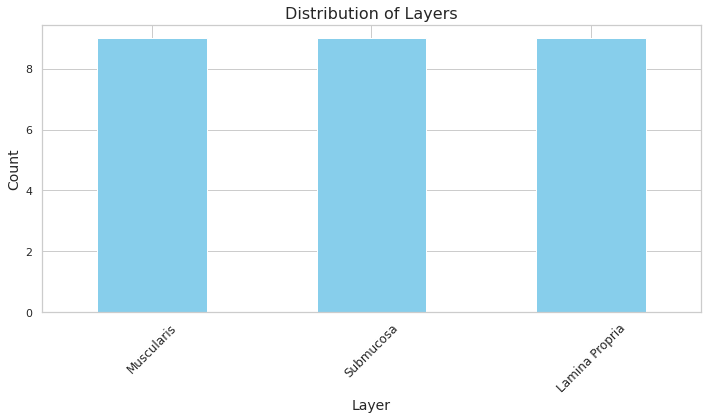

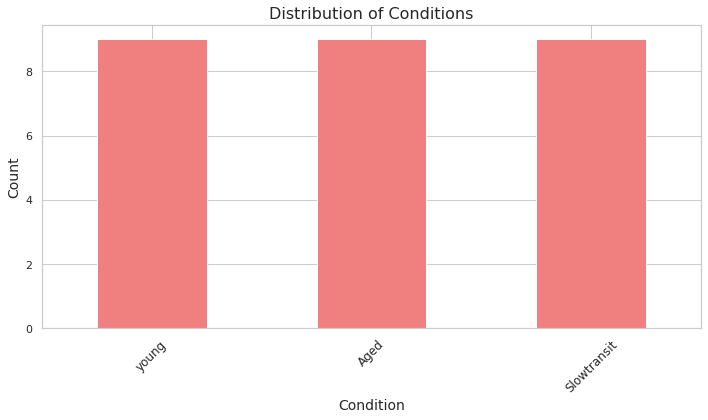

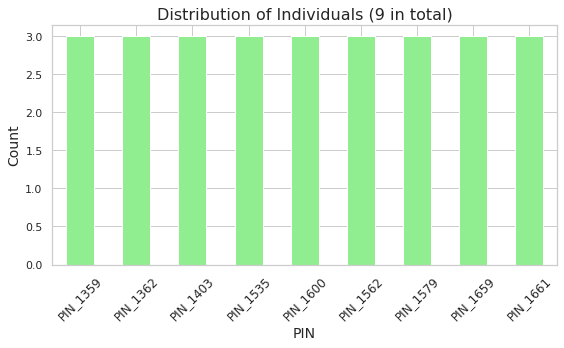

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming samples_desc is your DataFrame

# Plot for "layer"
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set(style="whitegrid")  # Optional, for additional styling

layer_plot = samples_desc["layer"].value_counts().plot.bar(rot=0, color='skyblue')
plt.title("Distribution of Layers", fontsize=16)
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Adjust rotation for better visibility
plt.tight_layout()  # Optional, to prevent clipping of labels
plt.show()

# Plot for "condition"
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set(style="whitegrid")  # Optional, for additional styling

condition_plot = samples_desc["condition"].str.replace(" ","").value_counts().plot.bar(rot=0, color='lightcoral')
plt.title("Distribution of Conditions", fontsize=16)
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Adjust rotation for better visibility
plt.tight_layout()  # Optional, to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
sns.set(style="whitegrid")  # Optional, for additional styling

pin_plot = samples_desc["PIN"].value_counts().plot.bar(rot=0, color='lightgreen')
plt.title(f"Distribution of Individuals ({int(samples_desc.shape[0]/3)} in total)", fontsize=16)
plt.xlabel("PIN", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Adjust rotation for better visibility
plt.tight_layout()  # Optional, to prevent clipping of labels
plt.show()


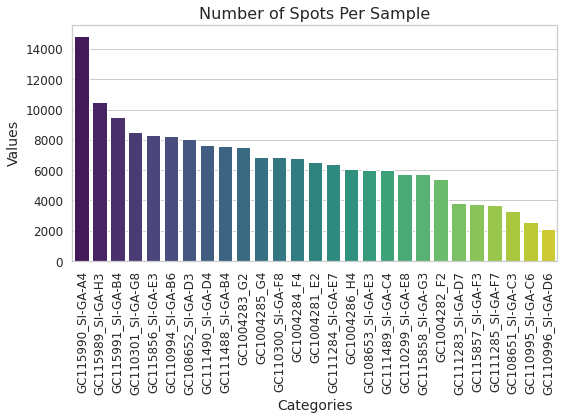

In [8]:
sorted_adatas = pd.Series(adatas_size).sort_values(ascending=False)

# Plot the sorted data
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.set(style="whitegrid")
sns.barplot(x=sorted_adatas.index, y=sorted_adatas.values, palette="viridis")

plt.title("Number of Spots Per Sample", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
merged=(samples_desc.set_index("GC code")
             .join([loaded_adata.obs["batch"].value_counts()])
             .reset_index()
             .sort_values(by="batch", ascending=False)
             .rename(columns={"batch": "spot count"}))
merged

,GC code,PIN,sample name,layer,condition,spot count
25,GC115990_SI-GA-A4,PIN_1661,1661_2,Submucosa,young,14859
24,GC115989_SI-GA-H3,PIN_1661,1661_1,Muscularis,young,10517
26,GC115991_SI-GA-B4,PIN_1661,1661_3,Lamina Propria,young,9488
11,GC110301_SI-GA-G8,PIN_1535,1535_3,Lamina Propria,Aged,8547
21,GC115856_SI-GA-E3,PIN_1659,1659_1,Muscularis,Aged,8333
12,GC110994_SI-GA-B6,PIN_1600,1600_1,Muscularis,Slowtransit,8224
7,GC108652_SI-GA-D3,PIN_1403,1403_2,Submucosa,Slowtransit,8045
20,GC111490_SI-GA-D4,PIN_1579,1579_3,Lamina Propria,young,7635
18,GC111488_SI-GA-B4,PIN_1579,1579_1,Muscularis,young,7589
2,GC1004283_G2,PIN_1359,1359_3,Lamina Propria,young,7525


In [11]:
merged.sort_values(by=["PIN","spot count"])

,GC code,PIN,sample name,layer,condition,spot count
1,GC1004282_F2,PIN_1359,1359_2,Submucosa,young,5395
0,GC1004281_E2,PIN_1359,1359_1,Muscularis,young,6531
2,GC1004283_G2,PIN_1359,1359_3,Lamina Propria,young,7525
5,GC1004286_H4,PIN_1362,1362_3,Lamina Propria,Aged,6058
3,GC1004284_F4,PIN_1362,1362_1,Muscularis,Aged,6808
4,GC1004285_G4,PIN_1362,1362_2,Submucosa,Aged,6894
6,GC108651_SI-GA-C3,PIN_1403,1403_1,Muscularis,Slowtransit,3337
8,GC108653_SI-GA-E3,PIN_1403,1403_3,Lamina Propria,Slowtransit,6035
7,GC108652_SI-GA-D3,PIN_1403,1403_2,Submucosa,Slowtransit,8045
9,GC110299_SI-GA-E8,PIN_1535,1535_1,Muscularis,Aged,5771
